<a href="https://colab.research.google.com/github/sujithgunturu/Agron-893/blob/master/EBT_jacobean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
%matplotlib inline
import pandas as pd                    # Import pandas for reading env data
import numpy as np                     # Import array funtions
import math                            # Import all math functions
import matplotlib.pyplot as plt        # Import plotting functions
import ephem as em                     # Import pyephem to get daylight data
from datetime import *   
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import pchip
from scipy.integrate import odeint, RK45,ode
import scipy.linalg as sla
from autograd import grad, jacobian
from scipy.cluster.vq import kmeans2
import time
from time import perf_counter
import autograd

In [66]:
"""Model Class Definition"""
class Model(object):
    
    #Attributes we want each instance of model to have
    def __init__(self,Eqns):
        self.Eqns = Eqns  #
        #self.n_var = len(Eqns)
        self.solution=[]  # creates a new empty list for each model
        self.params=None   # Initialize parameter values
        
        self.y0=None      # Initialze initial state variables
        
        self.t=None       # Initialie array of times at which solutions are sought
        
        self.Env=None     # Set flag that the simulation environment is not yet defined
                          #    When it is, it will most likely be an array with one
                          #    row per measurement time and one column per environmental
                          #    variable.
        self.day_length=None
        
                    
    # Store a vector of desired solution times
    def new_soltimes(self,t):
        self.t=np.array(t)
    
    # Store a vector of desired state variable initial conditions
    def new_ICs(self,y0):
        self.y0=np.array(y0)
    
    # Store a vector of model parameters - this is used during parameter estimation
    def new_params(self,params):
        self.params=np.array(params)
        
    
    """ The following two methods are overloaded in the users class definition """
    
    # Fetch the environmental information from a file.  "Environ" is 
    # whatever information is needed to do this.
    def FetchEnviron(self,Environ):
        pass
        
    
  
    def GetEnvData(self,t):
        self.Edat=np.zeros(9)
        
        
    # Run the model
    def Run(self,ICs=None,params=None,t=None,Environ=None):
        
        # Perform any needed initializations
        if ICs is not None    : self.new_ICs(ICs)
        if params is not None : self.new_params(params)
        if t is not None      : self.new_soltimes(t)
        if Environ is not None: self.FetchEnviron(Environ)
        self.t = np.linspace(0, 100, 100)
        
        
        # if self.params is None or self.y0 is None or self.t is None or self.Env is None:
        #     raise Exception("Prequisite data for run is incomplete")
        
        # Define the function that is passed to odeint
        self.count = 0
        def deriv(y,t,model):
            
            # Obtain the environmental data for this value of t
            #self.Edat
            # Compute required derivatives.  This will entail using data that
            # should be ready and waiting in model.par and model.Edat

            return model.Eqns(t, y, model.params, model)
            


        # Call odeint to itegrate diffeq system.  All the odeint arguments are shown
        # here in case we want to modify something in a future version.  (It is, perhaps,
        # noteworthy that some of the extra parameters apparenly specify the order of 
        # integration to be peformed.)
        
        return odeint(deriv,           # Computes the derivative of y at t
                      self.y0,         # Initial condition on y (can be a vector) 
                      self.t,          # The time points for which to solve for y
                      args=(self,),    # Extra arguments to pass to function (self reference to
                                       #   this model instance)
                      Dfun=None,       # Gradient (Jacobian) of func 
                      col_deriv=0,     # True if Dfun defines derivatives down columns
                      full_output=0,   # True if to return a dictionary of 
                                       #   optional outputs as the second output
                      printmessg=0,    # Whether to print the convergence message
                      tfirst=False,    # If True, the first two arguments of func 
                                       #   (and Dfun, if given) must t, y
                                
        #  See https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
        #     ror the definition of these arguments
        
                      ml=None,           
                      mu=None, 
                      rtol=None, 
                      atol=None, 
                      tcrit=None, 
                      h0=0.0, 
                      hmax=0.0, 
                      hmin=0.0, 
                      ixpr=0, 
                      mxstep=0, 
                      mxhnil=0, 
                      mxordn=12, 
                      mxords=5, 
                      )

In [67]:
class mark_0_wheat(Model):
    def __init__(self,Eqns):
        Model.__init__(self,Eqns)
        #self.n_var = Model.n_var
    def FetchEnviron(self, Environ):
        self.start_date = Environ[0]
        self.end_date = Environ[1]
        file = Environ[2]
    
        # reading the data
        w = pd.read_csv(file)

        # change this data into a numpy array to use the where function
        day_data = np.asarray(w)
    
        #find row index of selected start and stop dates, here we choose April 1st through November 11th
        start_index = int(np.where(day_data == self.start_date)[0])
        stop_index = int(np.where(day_data == self.end_date)[0])

        
        self.Env = day_data[start_index:stop_index+1, 2:].astype(np.float)
        
        self.t = np.arange(0,len(self.Env))          
        
        self.loc_data = self.Env
      
        self.T_avg  = pchip(self.t,(self.loc_data[:,0] + self.loc_data[:,1])/2)  #average temperature per day (max+min)/2
                                                                                 #use the pchip command to interpolate the
        self.I = pchip(self.t,(self.loc_data[:,-3])*0.0864)                      #the data since odeint takes noninteger vals
        
        self.Edat = [self.T_avg, self.I]
        
        def rhs(self, X, t):
            dTT = dtt(X, t) 
            dLAI = dlai(X, t)
            dB = dcho(X, t)       
            return np.array([dTT, dLAI, dB])


In [68]:
class Build_Jacobean(Model):
    def __init__(self, system, statevars, statevars0, parameters, paramvalues):
      self.system = system
      self.statevars = statevars
      self.statevars0 = statevars0
      self.parameters = parameters
      self.paramvalues = paramvalues

    def Run_Model(self, environ, t):
        self.Modelinstace=self.Modelinstace= mark_0_wheat(self.system)
        self.Modelinstace.new_ICs(self.statevars0[:len(self.statevars)])
        self.Modelinstace.new_soltimes(t)
        self.Modelinstace.new_params(self.paramvalues)
        self.Modelinstace.FetchEnviron(environ)

        Jac_X = autograd.jacobian(self.system,argnum=1)
        Jac_P = autograd.jacobian(self.system,argnum=2)
        
        P = self.paramvalues
        n_vars = len(self.statevars)
        n_params = len(self.parameters)
        n_depend = n_vars*n_params
        def rhs_fn(X,t):                                    #for odeint
        #def rhs_fn(t,X):                                   #for solve_ivp
            # split into variables and parameter derivatives
            Xv = X[:n_vars]
            Xd = X[n_vars:].reshape((n_vars,n_params))

          # initialize the derivative vector
            d = np.zeros_like(X)
            # copy the original ODE part
            d[:n_vars] = self.system(t,Xv,P, self.Modelinstace)
            JX = Jac_X(t, np.array(Xv), np.array(P), self.Modelinstace)
            JP = Jac_P(t, np.array(Xv), np.array(P), self.Modelinstace)
            # find the RHS for the parameter derivatives and reflatten to a vector
            d[n_vars:] = (JX.dot(Xd) + JP).flatten()

            return d
        # initial conditions
        x0 = self.statevars0
        # solve the odes
        
        #soln = solve_ivp(rhs_fn, (t[0],t[-1]), x0, t_eval=t)
        self.solution = odeint(rhs_fn, x0, t)
        
        return self.solution
    def plotjacobeans(self):
      plt.plot(self.solution[:, :len(self.statevars)])
      plt.show()
      for i in range(len(self.statevars)):
        plt.figure()
        plt.title(self.statevars[i])
        plt.plot(solution[:, len(self.statevars) + i*len(self.parameters): len(self.statevars) + i*len(self.parameters) + len(self.parameters)])
        forlabel = []
        for param in self.parameters:
          forlabel.append(str(self.statevars[i]) +"_"+ str(param))
        plt.legend(forlabel)
        plt.show()


    

In [69]:
T_base =  0
alpha =   1.0125e-4
LAImax =  7.0
TTL =       21600/24
RUE =     1.5
K =       0.7
TTM =    43200/24
transition_period = 2 #time needed for lai and cho to transition to no growth
lai_transition_tt = 20*transition_period  #thermal time needed for lai transition to no growth
cho_transition_tt = 28*transition_period  #thermal time needed for cho transition to no growth

paramvals=np.array([T_base, alpha, LAImax, TTL, RUE, K, TTM, transition_period, lai_transition_tt, cho_transition_tt])
ICs = [0.1, 0.1, 0.1]

In [70]:
def rhs(t, X, P, model):
  TT, LAI, CHO = X
  T_base, alpha, LAImax, TTL, RUE, K, TTM, transition_period, lai_transition_tt, cho_transition_tt = P
  dTT = model.T_avg(t)
  dLAI = alpha*model.T_avg(t)*LAI*(LAImax - LAI)*(-1/2)*(np.tanh(((TT-TTL))/lai_transition_tt)-1)
  dCHO = RUE*(1-np.exp(-K*LAI))*model.I(t)*(-1/2)*(np.tanh((TT-TTM)/cho_transition_tt) - 1)
  return np.array([dTT, dLAI, dCHO])  

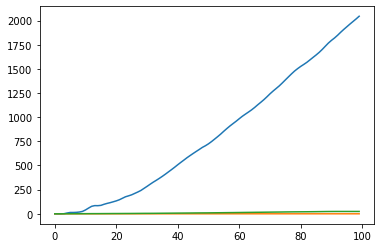

In [71]:
wheat= mark_0_wheat(rhs)
wheat.new_ICs(ICs)
t = np.linspace(0, 100, 100)
wheat.new_soltimes(t)
wheat.new_params(paramvals)
OurEnv = ('2018-04-01','2018-10-01','weather18.csv') 
# OurEnv = ('weather18.csv', )
wheat.FetchEnviron(OurEnv)
soln = wheat.Run()
import matplotlib.pyplot as plt
_ = plt.plot(soln)

In [72]:
variables = ('TT','LAI', 'CHO')
parameters  = ('T_base', 'alpha', 'LAImax', 'TTL', 'RUE', 'K', 'TTM', 'transition_period', 'lai_transition_tt', 'cho_transition_tt')

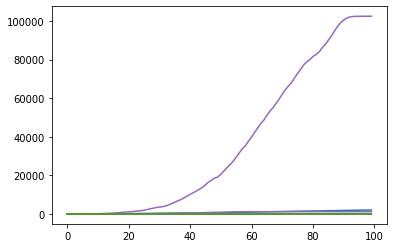

In [73]:
params0 = [0.]*len(variables)*len(parameters)
t = np.linspace(0., 100., 100)
sweetjacobean  = Build_Jacobean(rhs, variables, ICs + params0, parameters, paramvals)
solution = sweetjacobean.Run_Model(('2018-04-01','2018-10-01','weather18.csv') , t) 
_ = plt.plot(solution)

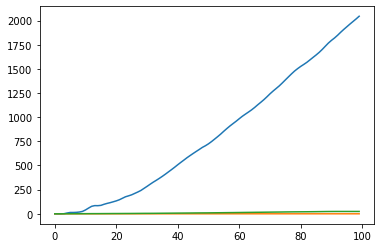

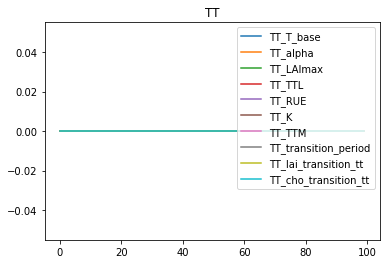

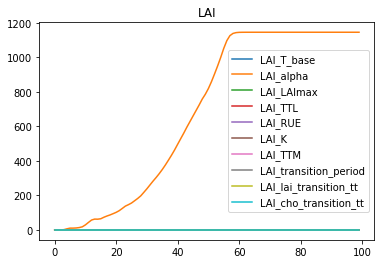

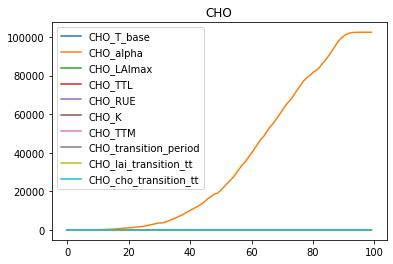

In [74]:
sweetjacobean.plotjacobeans()

In [75]:
class Generate_Fisher_Matrix(Build_Jacobean):
    def __init__(self, environments=[[]],covmatrix=None, betavector=0, w=np.linspace(0, 100, 100)):

        self.Build_Jacobean_instance = Build_Jacobean(rhs,variables, ICs + params0, parameters, paramvals)
        self.environments = environments
        self.covmatrix = np.array(covmatrix)
        self.betavector = np.array(betavector)
        self.w = w
    def Simulate(self, ICs, paramvals, t):
        simulation = []
        for environment in self.environments:
          soln = self.Build_Jacobean_instance.Run_Model(environment, t)
          simulation.append(soln)
        self.simulation = np.array(simulation)
        return self.simulation
       
    def Residuals(self, i):
        mean = [0.]*self.covmatrix.shape[0]
        modeloutput_i = self.simulation[0][i, :len(ICs)]
        diagonalmatrix_beta_2 =  np.diag(np.power(modeloutput_i, self.betavector/2))
        res = diagonalmatrix_beta_2@np.linalg.inv(self.covmatrix)@diagonalmatrix_beta_2
        self.randomvectors = np.random.multivariate_normal(mean, res, len(w)) 
         
        return self.randomvectors
        

    def du_dr_i(self,i):
        summationarray = []
        q = self.covmatrix.shape[0]
        
        for index1 in range(q):
          for index2 in range(q):
            m1 = np.power(self.simulation[0][i][index1], (self.betavector/2))
            m2 = np.power(self.simulation[0][i][index1], (self.betavector/2))
            v = np.linalg.inv(self.covmatrix)
            m = m1 * m2
            #for l in range(q):
              #do something
            r = self.Residuals(i)[i]
            prod =   m*v[index1][index2]*r
          summationarray.append(prod)
        self.dudri = np.sum(summationarray, axis = 1)
        return self.dudri 

    def da_dth8_k_div_a(self, k, i):
         q = self.covmatrix.shape[0]
         term = 0.5 * (2 * np.pi)**q/2 * np.linalg.det((np.linalg.inv(self.covmatrix)))**-0.5 
         #dmdthetaarr = self.simulation[0][i][len(ICs)+k::len(paramvals)]
         dmdthetaarr = self.simulation[0][i][len(ICs):].reshape((-1, len(paramvals)))[:, k]
         summationarray = []
         
         for index in range(q):
           summationarray.append(dmdthetaarr[index]/self.simulation[0][i][index])
         
         self.dudth8kdiva = term *np.sum(summationarray)
         
         return self.dudth8kdiva
   
    def du_dth8_k(self, k, i):
        summation = []
        q = self.covmatrix.shape[0]
        #dmdthetaarr = self.simulation[0][k][len(ICs):]
        # dmdthetaarr = self.simulation[0][i][len(ICs)+k::len(paramvals)]
        dmdthetaarr = self.simulation[0][i][len(ICs):].reshape((-1, len(paramvals)))[:, k]
        for index1 in range(q):
          for index2 in range(q):
            beta_xi = self.betavector[index1]
            #should do the inverse or T
            m_xi_beta_inv = np.power(self.simulation[0][i][:q], self.betavector/2)[index1]
            dmdtheta_xi = dmdthetaarr[index1]
            m_sigma_beta = np.power(self.simulation[0][i][:q], self.betavector/2)[index2]
            
            
            beta_sigma = self.betavector[index2]
            m_sigma_beta_inv = np.power(self.simulation[0][i][:q], self.betavector/2)[index2]
            dmdtheta_sigma = dmdthetaarr[index2]
            m_xi_beta = np.power(self.simulation[0][i][:q], self.betavector/2)[index1]
            
            term = (( (beta_xi * m_xi_beta_inv * dmdtheta_xi * m_sigma_beta)) 
            + ( m_sigma_beta_inv  * m_xi_beta )) * self.Residuals(i)[i][index1] * self.Residuals(i)[i][index2] * np.linalg.inv(self.covmatrix)[index1][index2]
            
            summation.append(term)
        
            self.dudth8k = -1 * 0.25 *np.sum(summation)
            return self.dudth8k


    def dS_dth8_k(self, k, i):
        term1 = self.du_dr_i(i) @ self.simulation[0][i][len(ICs)+k::len(paramvals)]
        term2 = self.da_dth8_k_div_a(k, i)
        term3 = self.du_dth8_k(k, i)

        return term1 + term2 + term3

    def S_matrix(self):
        matrix = []
        largematrix = []
        for i in range(len(self.w)):
          dudr = self.du_dr_i(i)
          for k in range(len(parameters)):
            #dadthdiva = self.da_dth8_k_div_a(k, i)
            #dudthk = self.du_dth8_k(k, i)
            
            dSdth8k = self.dS_dth8_k(k, i)
            print(dSdth8k)
            matrix.append([dSdth8k])
          matrix = np.array(matrix)
          hmatrix = matrix @ matrix.T
          matrix = []
          largematrix.append(hmatrix)
        result = np.sum(largematrix, axis = 0)
        return result

class Analyse_S_matrix:
    def __init__(self, model):
        self.S_Matrix_fisher = model.S_matrix()
    def S_test(self):
        return np.linalg.det(self.S_Matrix_fisher) == 0
    def Ortho_Null(self, S):
        pass


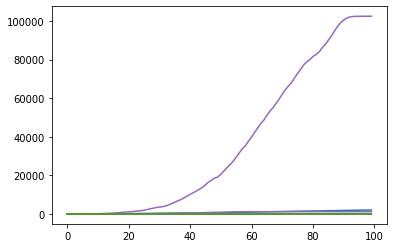

In [76]:
# environments = [['Weather_data_2020.csv'], ['Weather_data_2020.csv']]
a = np.diag([5,5,5])
beta = np.zeros(3)
environments = [('2018-04-01','2018-10-01','weather18.csv') ]
w = np.linspace(0, 100, 100)
osufisher = Generate_Fisher_Matrix(environments, a,betavector=beta,w=w)
simulation = osufisher.Simulate(ICs, paramvals, w)
_ = plt.plot(simulation[0])

In [ ]:
print(osufisher.du_dr_i(9))
print(osufisher.da_dth8_k_div_a(0, 70))
print(osufisher.du_dth8_k(0, 30))
print(osufisher.dS_dth8_k(0, 30))
print(osufisher.Residuals(1))

In [ ]:
S = osufisher.S_matrix()
S

In [ ]:
np.linalg.det(S)